# Data conversion script
Convert data from TFRecord with nonstand data format to a standard one

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
from glob import glob
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# frontend imports
from keras_yolov2.yolo_loss import YoloLoss
from keras_yolov2.map_evaluation import MapEvaluation
from keras_yolov2.utils import decode_netout, import_feature_extractor, import_dynamically
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np
import sys
import cv2
import os

# preprocessing imports
import copy
import os
import xml.etree.ElementTree as et

import cv2
import numpy as np
from imgaug import augmenters as iaa
from imgaug.augmentables import BoundingBox, BoundingBoxesOnImage
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

from keras_yolov2.utils import BoundBox, bbox_iou

## Input configurations

paths to data and config constants

In [2]:
# Yolo class input parameters
config = {
    "model" : {
        "backend":              "Full Yolo",
        "input_size_w":         448,
        "input_size_h":         448,
        "gray_mode":            False,
        "anchors":              [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
        "max_box_per_image":    10,        
        "labels":               ["dam_image"]
    },

    "parser_annotation_type":    "xml",

    "train": {
        "train_csv_file":       "",
        "train_csv_base_path":  "",
        "train_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_image_folder",
        "train_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_annot_folder",     

        "callback":             None,
        "train_times":          8,
        "pretrained_weights":   "",
        "batch_size":           16,
        "learning_rate":        1e-4,
        "nb_epochs":            40,
        "warmup_epochs":        3,

        "workers":              12,
        "max_queue_size":       40,
        "early_stop":           True,
        "tensorboard_log_dir":  "./logs/1",

        "object_scale":         5.0 ,
        "no_object_scale":      1.0,
        "coord_scale":          1.0,
        "class_scale":          1.0,

        "saved_weights_name":   "tiny_yolo_backend_best.h5",
        "debug":                False
    },

    "valid": {
        "iou_threshold":        "0.5",
        "score_threshold":      "0.5",
        "valid_csv_file":       "",
        "valid_csv_base_path":  "",
        "valid_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_image_folder",
        "valid_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_annot_folder",

        "valid_times":          1
    },

    "backup":{
        "create_backup":        True,
        "redirect_model":       True,
        "backup_path":          "../backup",
        "backup_prefix":        "Tiny_yolo_VOC"
    }
}


In [3]:
input_path = '../datasets/bbox_data/*.gz'

input_files= glob(input_path)
#print("input path is ", input_files)
print(input_files[0:2])
data_path = '../datasets/raw/bbox_data.gz'

['../datasets/bbox_data/dam-data-000.gz', '../datasets/bbox_data/dam-data-001.gz']


In [4]:
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'image/height': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/width': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/filename': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/source_id': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/format': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/channel/B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'image/channel/B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'image/channel/B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'image/channel/AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'image/channel/NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/object/bbox/xmin': tf.io.FixedLenFeature(1, dtype=tf.int64), 
        'image/object/bbox/xmax': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/object/bbox/ymin': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/object/bbox/ymax': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/object/class/text': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/object/class/label': tf.io.FixedLenFeature(1, dtype=tf.int64)
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)

def parse_features(feature):
    features = [feature[x] for x in ['image/width', 'image/height', 'image/filename', 'image/object/class/label']]
    
    # locations
    xmin = feature['image/object/bbox/xmin']
    xmax = feature['image/object/bbox/xmax']
    ymin = feature['image/object/bbox/ymin']
    ymax = feature['image/object/bbox/ymax']
    
    obj = tf.concat([xmin, xmax, ymin, ymax], axis=0)
    
    return obj

In [5]:
dataset = tf.data.TFRecordDataset(input_files[0], compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
dataset = dataset.map(parse_features)


for x in dataset.take(1):
    print(x)

tf.Tensor([107 150 149 106], shape=(4,), dtype=int64)


## YOLO frontend

adjusted yolo frontend code

In [6]:
# changes include writing to TFRecord format
class YOLO(object):
    def __init__(self, backend, input_size, labels, max_box_per_image, anchors, gray_mode=False):

        self._input_size = input_size
        self._gray_mode = gray_mode
        self.labels = list(labels)
        self._nb_class = len(self.labels)
        self._nb_box = len(anchors) // 2
        self._anchors = anchors

        self._max_box_per_image = max_box_per_image

        ##########################
        # Make the model
        ##########################

        # make the feature extractor layers
        if self._gray_mode:
            self._input_size = (self._input_size[0], self._input_size[1], 1)
            input_image = Input(shape=self._input_size)
        else:
            self._input_size = (self._input_size[0], self._input_size[1], 3)
            input_image = Input(shape=self._input_size)

        self._feature_extractor = import_feature_extractor(backend, self._input_size)

        print(self._feature_extractor.get_output_shape())
        self._grid_h, self._grid_w = self._feature_extractor.get_output_shape()
        features = self._feature_extractor.extract(input_image)

        # make the object detection layer
        output = Conv2D(self._nb_box * (4 + 1 + self._nb_class),
                        (1, 1), strides=(1, 1),
                        padding='same',
                        name='Detection_layer',
                        kernel_initializer='lecun_normal')(features)
        output = Reshape((self._grid_h, self._grid_w, self._nb_box, 4 + 1 + self._nb_class), name="YOLO_output")(output)

        self._model = Model(input_image, output)

        # initialize the weights of the detection layer
        layer = self._model.get_layer("Detection_layer")
        weights = layer.get_weights()

        new_kernel = np.random.normal(size=weights[0].shape) / (self._grid_h * self._grid_w)
        new_bias = np.random.normal(size=weights[1].shape) / (self._grid_h * self._grid_w)

        layer.set_weights([new_kernel, new_bias])

        # print a summary of the whole model
        self._model.summary()

        # declare class variables
        self._batch_size = None
        self._object_scale = None
        self._no_object_scale = None
        self._coord_scale = None
        self._class_scale = None
        self._debug = None
        self._warmup_batches = None

    def load_weights(self, weight_path):
        self._model.load_weights(weight_path)

    def train(self, train_imgs,  # the list of images to train the model
              valid_imgs,  # the list of images used to validate the model
              train_times,  # the number of time to repeat the training set, often used for small datasets
              valid_times,  # the number of times to repeat the validation set, often used for small datasets
              nb_epochs,  # number of epoches
              learning_rate,  # the learning rate
              batch_size,  # the size of the batch
              warmup_epochs,  # number of initial batches to let the model familiarize with the new dataset
              object_scale,
              no_object_scale,
              coord_scale,
              class_scale,
              saved_weights_name='best_weights.h5',
              debug=False,
              workers=3,
              max_queue_size=8,
              early_stop=True,
              custom_callback=[],
              tb_logdir="./",
              train_generator_callback=None,
              iou_threshold=0.5,
              score_threshold=0.5):

        self._batch_size = batch_size

        self._object_scale = object_scale
        self._no_object_scale = no_object_scale
        self._coord_scale = coord_scale
        self._class_scale = class_scale

        self._debug = debug

        #######################################
        # Make train and validation generators
        #######################################

        generator_config = {
            'IMAGE_H': self._input_size[0],
            'IMAGE_W': self._input_size[1],
            'IMAGE_C': self._input_size[2],
            'GRID_H': self._grid_h,
            'GRID_W': self._grid_w,
            'BOX': self._nb_box,
            'LABELS': self.labels,
            'CLASS': len(self.labels),
            'ANCHORS': self._anchors,
            'BATCH_SIZE': self._batch_size,
            'TRUE_BOX_BUFFER': self._max_box_per_image,
        }

        if train_generator_callback is not None:
            basepath = os.path.dirname(train_generator_callback)
            sys.path.append(basepath)
            custom_callback_name = os.path.basename(train_generator_callback)
            custom_generator_callback = import_dynamically(custom_callback_name)
        else:
            custom_generator_callback = None
        
    
        train_generator = BatchGenerator_tf(train_imgs,
                                           generator_config,
                                           norm= self._feature_extractor.normalize,
                                           callback=custom_generator_callback)

        valid_generator = BatchGenerator_tf(valid_imgs,
                                           generator_config,
                                           norm= self._feature_extractor.normalize,
                                           callback=custom_generator_callback)
        

        # TODO: warmup is not working with new loss function formula
        self._warmup_batches = warmup_epochs * (train_times * len(train_generator) + valid_times * len(valid_generator))

        ############################################
        # Compile the model
        ############################################

        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        loss_yolo = YoloLoss(self._anchors, (self._grid_w, self._grid_h), self._batch_size,
                             lambda_coord=coord_scale, lambda_noobj=no_object_scale, lambda_obj=object_scale,
                             lambda_class=class_scale)
        
        self._model.compile(loss=loss_yolo, optimizer=optimizer)

        ############################################
        # Make a few callbacks
        ############################################

        early_stop_cb = EarlyStopping(monitor='val_loss',
                                      min_delta=0.001,
                                      patience=3,
                                      mode='min',
                                      verbose=1)

        tensorboard_cb = TensorBoard(log_dir=tb_logdir,
                                     histogram_freq=0,
                                     # write_batch_performance=True,
                                     write_graph=True,
                                     write_images=False)

        root, ext = os.path.splitext(saved_weights_name)
        ckp_best_loss = ModelCheckpoint(root + "_bestLoss" + ext,
                                        monitor='val_loss',
                                        verbose=1,
                                        save_best_only=True,
                                        mode='min',
                                        period=1)
        
        ckp_saver = ModelCheckpoint(root + "_ckp" + ext,
                                    verbose=1,
                                    period=10)
        
        map_evaluator_cb = MapEvaluation(self, valid_generator,
                                         self.labels,
                                         save_best=True,
                                         save_name=root + "_bestMap" + ext,
                                         tensorboard=tensorboard_cb,
                                         iou_threshold=iou_threshold,
                                         score_threshold=score_threshold)

        if not isinstance(custom_callback, list):
            custom_callback = [custom_callback]
        callbacks = [ckp_best_loss, ckp_saver, tensorboard_cb, map_evaluator_cb] + custom_callback
        if early_stop:
            callbacks.append(early_stop_cb)

        #############################
        # Start the training process
        #############################
        
        self._model.fit(x=train_generator(mode='train').repeat(), 
                        validation_data = valid_generator(mode='valid'),
                        validation_steps = int(np.ceil((len(valid_imgs) * 100) / batch_size)),
                        epochs=warmup_epochs + nb_epochs, 
                        steps_per_epoch= int(np.ceil((len(train_imgs) * 100) / batch_size)),
                        callbacks = callbacks,
                        shuffle=True,
                        max_queue_size=max_queue_size,
                        workers=workers)
        

    def get_inference_model(self):
        return self._model

    def predict(self, image, iou_threshold=0.5, score_threshold=0.5):

        if len(image.shape) == 3 and self._gray_mode:
            if image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image[..., np.newaxis]
        elif len(image.shape) == 2 and not self._gray_mode:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif len(image.shape) == 2:
            image = image[..., np.newaxis]

        image = cv2.resize(image, (self._input_size[1], self._input_size[0]))
        image = self._feature_extractor.normalize(image)
        if len(image.shape) == 3:
            input_image = image[np.newaxis, :]
        else:
            input_image = image[np.newaxis, ..., np.newaxis]

        netout = self._model.predict(input_image)[0]

        boxes = decode_netout(netout, self._anchors, self._nb_class, score_threshold, iou_threshold)

        return boxes

In [7]:
backend= 'Full Yolo'
input_size = [257,257]
labels = ['dam_image']
max_box_per_image = 10
anchors = config['model']['anchors']

yolo = YOLO(backend, input_size, labels, max_box_per_image, anchors, gray_mode=False)



Loading pretrained weights: ./backend_weights/full_yolo_backend.h5
(8, 8)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 257, 257, 3)]     0         
_________________________________________________________________
Full_YOLO_backend (Model)    (None, 8, 8, 1024)        50547936  
_________________________________________________________________
Detection_layer (Conv2D)     (None, 8, 8, 30)          30750     
_________________________________________________________________
YOLO_output (Reshape)        (None, 8, 8, 5, 6)        0         
Total params: 50,578,686
Trainable params: 50,558,014
Non-trainable params: 20,672
_________________________________________________________________


## Yolo batch generator

In [8]:
generator_config = {
    'IMAGE_H': 257,
    'IMAGE_W': 257,
    'IMAGE_C': 3,
    'GRID_H': 8,
    'GRID_W': 8,
    'BOX': 5,
    'LABELS': ['dam_image'],
    'CLASS': 1,
    'ANCHORS': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
    'BATCH_SIZE': 10,
    'TRUE_BOX_BUFFER': 50,
}

In [9]:

class BatchGenerator_tf(object):
    def __init__(self, tfr_path, config, shuffle=True, jitter=True, norm=None, callback=None):
        
        # Path to the tfrecords
        self._tfr_path = tfr_path
        # config file
        self._config = config

        self._shuffle = shuffle
        self._jitter = jitter
        
        #obsolete parameter now?
        self._norm = norm
        #possible obsolete?
        self._callback = callback
    
        self._anchors = [BoundBox(0, 0, config['ANCHORS'][2 * i], config['ANCHORS'][2 * i + 1])
                         for i in range(int(len(config['ANCHORS']) // 2))]
        
        
        # augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self._aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                iaa.Fliplr(0.5),  # horizontally flip 50% of all images
                iaa.Flipud(0.2),  # vertically flip 20% of all images
                sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent
                    rotate=(-5, 5),  # rotate by -45 to +45 degrees
                    shear=(-5, 5),  # shear by -16 to +16 degrees
                    # order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ))
            ],
            random_order=True
        )
    
        # Most likely obsolete
    def __len__(self):
        # 100: there are 100 examples per tfrecord in my specific example
        return int(np.ceil(float(len(self._tfr_path) * 100) / self._config['BATCH_SIZE']))
    
    # most likely obsolete
    def num_classes(self):
        return len(self._config['LABELS'])
    
    # most likely obsolete
    def size(self):
        return len(self._tfr_path) * 100
    
    
    def parse_serialized_example(self, example_proto):
        ''' Parser function
        Useful for functional extraction, i.e. .map functions

        Args:
            example_proto: a serialized example

        Returns:
            A dictionary with features, cast to float32
            This returns a dictionary of keys and tensors to which I apply the transformations.
        '''
        # feature columns of interest
        featuresDict = {
            'image/height': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/width': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/filename': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/source_id': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/format': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/channel/B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
            'image/channel/B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
            'image/channel/B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
            'image/channel/AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
            'image/channel/NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/PIXEL_LABEL': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/object/bbox/xmin': tf.io.FixedLenFeature(1, dtype=tf.int64), 
            'image/object/bbox/xmax': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/object/bbox/ymin': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/object/bbox/ymax': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/object/class/text': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/object/class/label': tf.io.FixedLenFeature(1, dtype=tf.int64)
        }

        return tf.io.parse_single_example(example_proto, featuresDict)
    def stretch_image_colorspace(self, img):
        max_val = tf.reduce_max(img)
        return tf.cast(tf.divide(img, max_val), tf.float32)
    
    def parse_features(self, features):
        rgb_chan = ['image/channel/' + x for x in ['B4', 'B3', 'B2']]
        
        img_chan = [features[x] for x in rgb_chan if x in rgb_chan]
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        
        # stretch color spaces of the RGB channels
        #if stretch_colorspace:
        img = self.stretch_image_colorspace(img)
        
        
        # ===============
        # bounding box locations
        # ===============
        
        xmin = features['image/object/bbox/xmin']
        xmax = features['image/object/bbox/xmax']
        ymin = features['image/object/bbox/ymax']
        ymax = features['image/object/bbox/ymin']
        class_name = features['image/object/class/text']

        
        obj = [tf.concat([xmin, xmax, ymin, ymax], axis=0)]
        
        # possibly redundant, but now for safe keeping, (attempt at deepcopying the variable)
        orig_obj = tf.identity(obj)
        
        #image, all_objs = tf.numpy_function(self.aug_image,
        #                                    [img, obj, True],
        #                                    [tf.float32, tf.int64])
        
        # not actually a batch, just a single image
        x_batch, y_batch = tf.numpy_function(self.get_batch,
                                            [img, obj, self._config['ANCHORS'], class_name, True],
                                            [tf.float32, tf.float32])     
        
        return x_batch, y_batch
    
    
    def parse_features_annot(self, features):
        rgb_chan = ['image/channel/' + x for x in ['B4', 'B3', 'B2']]
        
        img_chan = [features[x] for x in rgb_chan if x in rgb_chan]
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        
        # stretch color spaces of the RGB channels
        img = self.stretch_image_colorspace(img)
        
        # ===============
        # bounding box locations
        # ===============
        
        xmin = features['image/object/bbox/xmin']
        xmax = features['image/object/bbox/xmax']
        ymin = features['image/object/bbox/ymax']
        ymax = features['image/object/bbox/ymin']
        class_name = features['image/object/class/text']

        all_obj = [tf.concat([xmin, xmax, ymin, ymax], axis=0)]
    
        # Create and preprocess images and labels for network
        x_batch, y_batch = tf.numpy_function(self.get_batch,
                                            [img, all_obj, self._config['ANCHORS'], class_name, False],
                                            [tf.float32, tf.float32]) 
        
        return x_batch, all_obj, class_name
    
    # needs editing 
    def get_batch(self,img, objs, anchors, class_names, jitter=True):
        '''
            Args:
            
            self:
            
            img: the image in question, parsed through a tfrecord
            
            objs: same as image, but the labels
            
            anchor_pos, parsed through the tfrecord function
            
            jitter: image augmentations yes or no
        
        '''
        all_anchors = [BoundBox(0, 0, anchors[2 * i], anchors[2 * i + 1])
                       for i in range(int(len(anchors) // 2))]
        # rewrite everything from batch level to single example
        #height width, channels from the image
        h, w, c = img.shape
        #code byte string to normal string
        class_names =[x.decode('utf-8') for x in class_names]
        
        BOX = self._config['BOX']
        LABELS = len(self._config['LABELS'])
        
        # self.config['image width'], also height, and second line grid sizes for heigh and width , respect
        x_batch = np.zeros((self._config['IMAGE_H'], self._config['IMAGE_W'], c))  # input images
        y_batch = np.zeros((self._config['GRID_H'], self._config['GRID_W'], BOX, 4 + 1 + LABELS)) # desired network output       
        
        # augment input image and fix object's position and size
        img, all_objs = self.aug_image(img, objs, jitter= jitter)
        
        
        
        # this is a valid for loop (belongs to a single example)
        for class_idx, obj in enumerate(all_objs):
            # Translation list (dictionaries are not a good combo with tensorflow): 
            # 0: xmin  1: xmax 2: ymin  3: ymax
    
            # xmax > xmin and ymax > ymin and name and obj['name'] in self._config['LABELS']: (fix this later!!!)
            # center = 127 pixels, grid =8, width = 256, then center is at 127 / 32 ~= 3rd grid cell in x direction
            # OBJ NAME DOES NOT WORK
            
            
            if obj[1] > obj[0] and obj[3] > obj[2] and class_names[class_idx] in self._config['LABELS']:
                center_x = .5 * (obj[0] + obj[1])
                center_x = center_x / (float(self._config['IMAGE_W']) / self._config['GRID_W'] ) 
                center_y = .5 * (obj[2] + obj[3])
                center_y = center_y / (float(self._config['IMAGE_H']) / self._config['GRID_H']) 
                
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
    
                if grid_x < self._config['GRID_W'] and grid_y < self._config['GRID_H']:
                    # Alter the below variable later, not relevant yet
                    obj_indx = self._config['LABELS'].index(class_names[class_idx]) # DOES NOT WORK
                    # center relative to grid cell pixels:
                    # if center is 10 pixels and grid cell is 32 pixels: center_w=5/16, "width is 5/16th of grid cell" 
                    center_w = (obj[1] - obj[0]) / (
                                float(self._config['IMAGE_W']) / self._config['GRID_W']) #self._config['IMAGE_W'], self._config['GRID_W']
                    center_h = (obj[3] - obj[2]) / (
                                float(self._config['IMAGE_H']) / self._config['GRID_H'])
    
                    box = [center_x, center_y, center_w, center_h]
    
                    # find the anchor that best predicts this box
                    # i.e.: the best anchor shape that fits the box
                    best_anchor = -1
                    max_iou = -1
    
    
                    shifted_box = BoundBox(0, 0, center_w, center_h)
    
                    # fit anchors, which "shape" out of all anchors fits the current bbox best?
                    for i in range(len(all_anchors)):
                        anchor = all_anchors[i]
                        iou = bbox_iou(shifted_box, anchor)
    
                        if max_iou < iou:
                            best_anchor = i
                            max_iou = iou
    
                    # assign ground truth x, y, w, h, confidence and class probs to y_batch
                    y_batch[grid_y, grid_x, best_anchor, 0:4] = box
                    y_batch[grid_y, grid_x, best_anchor, 4] = 1.
                    y_batch[grid_y, grid_x, best_anchor, 5 + obj_indx] = 1
    
        # assign input image to x_batch
        norm = 1
        if norm is not None:
            x_batch = img
        # deal with this later? or done earlier in tfrecord procedure
        #if self._norm is not None:
        #   x_batch[instance_count] = self._norm(img)
        else:
            # plot image and bounding boxes for sanity check
            for obj in all_objs:
                if obj[1] > obj[0] and obj[3] > obj[2]:
                    cv2.rectangle(img[..., 0:3], (obj[0], obj[2]), (obj[1], obj[3]),
                                  (255, 0, 0), 3)
                    cv2.putText(img[..., ::-1], 'DAM', (obj[0] + 2, obj[2] + 12), 0,
                                1.2e-3 * img.shape[0], (0, 255, 0), 2)
    
            x_batch[instance_count] = img
    
        
        return x_batch, y_batch.astype(np.float32)
        
    def aug_image(self, image, objs, jitter=True):
        h = image.shape[0]
        w = image.shape[1]
        all_objs = copy.deepcopy(objs)
        if jitter:
            bbs = []
            for obj in all_objs:
                # see parse image for the correspondence between numeric index and values
                xmin = obj[0]
                xmax = obj[1] 
                ymin = obj[2]
                ymax = obj[3]            
                bbs.append(BoundingBox(x1=xmin, x2=xmax, y1=ymin, y2=ymax))           
                bbs = BoundingBoxesOnImage(bbs, shape=image.shape)
                image, bbs = self._aug_pipe(image=image, bounding_boxes=bbs)
                bbs = bbs.remove_out_of_image().clip_out_of_image()
    
                if len(all_objs) != 0:
                    for i in range(len(bbs.bounding_boxes)):
                        all_objs[i][0] = bbs.bounding_boxes[i].x1 # xmin
                        all_objs[i][1] = bbs.bounding_boxes[i].x2 # xmax
                        all_objs[i][2] = bbs.bounding_boxes[i].y1 # ymin
                        all_objs[i][3] = bbs.bounding_boxes[i].y2 # ymax
        
        # resize the image to standard size
        image = cv2.resize(image, (self._config['IMAGE_W'], self._config['IMAGE_H'])) 
        '''
        if self._config['IMAGE_C'] == 1: #self._config['IMAGE_C']
            image = image[..., np.newaxis]
        '''    
        #image = image[..., ::-1]  
        
        # fix object's position and size
        for obj in all_objs:
            for attr in [0, 1]: #xmin, xmax
                obj[attr] = int(obj[attr] * float(self._config['IMAGE_W']) / w) 
                obj[attr] = max(min(obj[attr], self._config['IMAGE_W']), 0)
    
            for attr in [2, 3]: #ymin, ymax
                obj[attr] = int(obj[attr] * float(self._config['IMAGE_H']) / h) 
                obj[attr] = max(min(obj[attr], self._config['IMAGE_H']), 0)
        return image, all_objs
    
    
    def __call__(self, mode):
        if mode is None:
            mode= 'train'
            batch_size = self._config['BATCH_SIZE']
            
        dataset = tf.data.TFRecordDataset(self._tfr_path, compression_type='GZIP')
        dataset = dataset.map(self.parse_serialized_example)
        
        if mode is 'train':
            batch_size = self._config['BATCH_SIZE']
            dataset = dataset.map(self.parse_features)
            dataset = dataset.shuffle(buffer_size=1000)
            dataset = dataset.batch(batch_size, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            return dataset
    
        elif mode is 'valid':
            batch_size = self._config['BATCH_SIZE']
            dataset = dataset.map(self.parse_features)
            dataset = dataset.batch(batch_size, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            return dataset
        
        elif mode is 'map':
            batch_size = 1
            dataset = dataset.map(self.parse_features_annot)
            dataset = dataset.shuffle(buffer_size=1000)
            dataset = dataset.batch(batch_size, drop_remainder=False)
            dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            return dataset
        

In [10]:
batch = BatchGenerator_tf(input_files[1:2], generator_config)

dataset = batch(mode='train')
print(dataset)

#for x in dataset.take(1):
#    print(x)

<DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>


## plot images from the functions

tf.Tensor(
[[[[[0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]]

   [[0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]]

   [[0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.       ]
    [0.        0.        0.        0.        0.        0.    

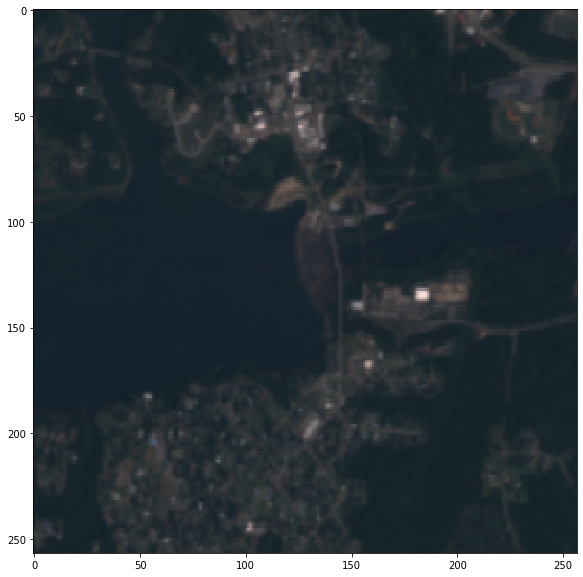

In [11]:
for image,y_batch in dataset.take(1):
    image = image[0,...]
    print(y_batch)

    #all_objs = all_objs[0]
    #bbox = BoundBox(all_objs.numpy()[0],all_objs.numpy()[2] , all_objs.numpy()[1], all_objs.numpy()[3] )


# get bounding boxes in matplotlib format
#plt_boxes = get_matplotlib_boxes([bbox],image.numpy().shape)
# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image.numpy()[:,:,0:3].squeeze(), cmap='gray')

print("the bounding box is supposed to be wrong when augmented since it is not the transformed box")
#for plt_box in plt_boxes:
#    ax.add_patch(plt_box)
#    #ax.imshow(pixel_label)
#plt.show()

In [12]:
#pprint(config)

print(input_files[0:1])

['../datasets/bbox_data/dam-data-000.gz']


In [13]:
generator_config = {
    'IMAGE_H': 257,
    'IMAGE_W': 257,
    'IMAGE_C': 3,
    'GRID_H': 8,
    'GRID_W': 8,
    'BOX': 5,
    'LABELS': ['dam_image'],
    'CLASS': 1,
    'ANCHORS': [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
    'BATCH_SIZE': 10,
    'TRUE_BOX_BUFFER': 50,
}


yolo.train(train_imgs = input_files[0:20],
           valid_imgs = input_files[20:25],
           train_times= 1,
           valid_times= 1,
           nb_epochs= 4,
           learning_rate= 0.00001,
           batch_size= 10,
           warmup_epochs= 3 ,
           object_scale= 5.0,
           no_object_scale=1.0,
           coord_scale=1.0,
           class_scale=1.0)

Instructions for updating:
Use `tf.cast` instead.
Epoch 1/7
199/200 [============================>.] - ETA: 0s - loss: 346.3471
Epoch 00001: val_loss improved from inf to 210.94394, saving model to best_weights_bestLoss.h5


dam_image 0.0000
mAP: 0.0000
mAP improved from 0 to 2.988531510329112e-07, saving model to best_weights_bestMap.h5.



AttributeError: 'ResourceSummaryWriter' object has no attribute 'add_summary'

In [ ]:
for i, (image,y_batch) in enumerate(dataset.take(1)):
    z = image
    y = y_batch
    print(np.squeeze(z.numpy()).shape)

In [ ]:
for image, bbox, class_name, labels in dataset.take(1):
    print(class_name)
    print(labels)
    


In [ ]:
def load_annotation(bbox, class_name, labels=['dam_image']):
    bbox = np.squeeze(bbox.numpy())
    class_name = np.squeeze(class_name.numpy(), axis=0)
    class_name = [x.decode("utf-8") for x in class_name]
    class_name = [labels.index(x) for x in class_name] # convert to integers
    all_objs = np.array([np.concatenate([bbox, class_name], axis=0)])
    
    # this is a conversion to xmin ymin xmax ymax!!!
    # DOES NOT WORK FOR MULTIPLE OBJECTS IN ONE IMAGE
    # but then again, the entire program is not build for it :)
    
    annots = []
    for obj in all_objs:
        annot = [obj[0], obj[2], obj[1], obj[3], obj[4]]
        annots += [annot]

    if len(annots) == 0:
        annots = [[]]

    return np.array(annots)
    


load_annotation(bbox, class_name)

In [ ]:
mode= 'valid'
mode is 'valid'